# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ



## Домашнее задание 2: сверточный классификатор.



### Общая информация



Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.



### Оценивание и штрафы



Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.



Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).



Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.



### О задании



В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [ ]:
import torch

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

import torchvision

import torchvision.transforms as transforms



import matplotlib.pyplot as plt

import numpy as np



from sklearn.model_selection import train_test_split

## 0. Загрузка данных



Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.



![title](https://pytorch.org/tutorials/_images/cifar10.png)






Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.




In [ ]:
def get_cifar10_data(batch_size, transform_train):

    torch.manual_seed(0)

    np.random.seed(0)



    transform_test = transforms.Compose(

        [transforms.ToTensor(),

         # Переводим цвета пикселей в отрезок [-1, 1]

         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

    )



    # Загружаем данные

    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,

                                               download=True, transform=transform_train)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,

                                           download=True, transform=transform_test)



    # В датасете определено разбиение только на train и test,

    # так что валидацию дополнительно выделяем из обучающей выборки

    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,

                                            shuffle=True, random_state=0)

    trainset = torch.utils.data.Subset(trainvalset, train_idx)

    valset = torch.utils.data.Subset(trainvalset, valid_idx)



    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,

                                               shuffle=True, num_workers=2)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,

                                             shuffle=False, num_workers=2)

    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,

                                              shuffle=False, num_workers=2)



    return train_loader, val_loader, test_loader



In [ ]:
transform = transforms.Compose(

        [transforms.ToTensor(),

         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)



train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,

                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 94621264.75it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

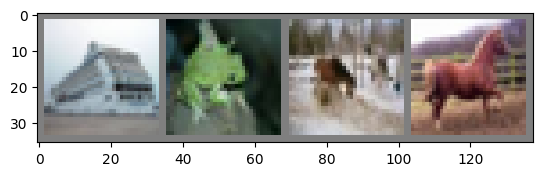

ship frog horse horse


In [ ]:
def imshow(img):

    img = img / 2 + 0.5

    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()





dataiter = iter(train_loader)

images, labels = next(dataiter)



imshow(torchvision.utils.make_grid(images[:4]))



classes = ('plane', 'car', 'bird', 'cat',

           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.



Используем сеть, основанную на одном блоке архитектуры ResNet.



<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>



__Указания:__



- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.

- Выход блока сократите до размерности 32х4х4, применив average pooling.

- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**



Определите архитектуру сети соответственно схеме и указаниям выше.



Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
n_classes = 10


class BasicBlockNet(nn.Module):

    def __init__(self):

        super().__init__()
        self.seq = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.Conv2d(32, 32, kernel_size=3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU()
        )
        self.passing = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=1)
        )
        self.relu = nn.ReLU(inplace=True)
        self.avg_pool = nn.AvgPool2d((8, 8))
        self.fc = nn.Linear(32 * 4 * 4, n_classes)


    def forward(self, x):
        block = self.seq(x)
        block += self.seq_2(x)
        block = self.relu(block)
        print(block.shape)
        block = self.avg_pool(block)
        print(block.shape)
        block = torch.flatten(block)
        out = self.fc(block)
        return out

    def forward(self, x):
        x = self.seq(x) + self.passing(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)
        return out

In [ ]:
net = BasicBlockNet()

net

BasicBlockNet(
  (seq): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (passing): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (relu): ReLU(inplace=True)
  (avg_pool): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:



**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).



__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
def test(model, loader):

    loss_log = []

    acc_log = []

    model.eval()

    for data, target in loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pred = torch.argmax(output, dim=1)
        acc = torch.mean((pred == target).float())
        loss = F.cross_entropy(output, target)
        loss_log.append(loss.item())
        acc_log.append(acc.item())
    return np.mean(loss_log), np.mean(acc_log)



def train_epoch(model, optimizer, train_loader):

    loss_log = []

    acc_log = []

    model.train()


    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        pred = torch.argmax(output, dim=1)
        acc = torch.mean((pred == target).float())
        loss =  F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return loss_log, acc_log



def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):

    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []



    for epoch in range(n_epochs):

        train_loss, train_acc = train_epoch(model, optimizer, train_loader)

        val_loss, val_acc = test(model, val_loader)


        train_loss_log.extend(train_loss)

        train_acc_log.extend(train_acc)



        val_loss_log.append(val_loss)

        val_acc_log.append(val_acc)



        print(f"Epoch {epoch}")

        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")

        print(f" val loss: {val_loss}, val acc: {val_acc}\n")



        if scheduler is not None:

            scheduler.step()



    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4920849611597915, train acc: 0.4689295508743858
 val loss: 1.2433924588751286, val acc: 0.5642287234042553

Epoch 1
 train loss: 1.16844334735295, train acc: 0.5931909441730004
 val loss: 1.2220513878984653, val acc: 0.5735815603682335

Epoch 2
 train loss: 1.072978331140452, train acc: 0.6252774876258055
 val loss: 1.0385814167083578, val acc: 0.639937943346957

Epoch 3
 train loss: 1.0122600416814604, train acc: 0.6472520566727605
 val loss: 1.06756047543059, val acc: 0.633843085106383

Epoch 4
 train loss: 0.9754986455715117, train acc: 0.661338632895698
 val loss: 1.0564981551880532, val acc: 0.6336436170212766

Epoch 5
 train loss: 0.9478675812428351, train acc: 0.671662803650774
 val loss: 0.9567588298878771, val acc: 0.6701462765957447

Epoch 6
 train loss: 0.9206068772938395, train acc: 0.6803506137684014
 val loss: 1.000053109767589, val acc: 0.6468528369639782

Epoch 7
 train loss: 0.9034799827736082, train acc: 0.6865900040108718
 val loss: 0.959649469

Посчитайте точность на тестовой выборке:

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.6881966560509554


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [ ]:
import seaborn as sns

In [ ]:
sns.set_style("darkgrid")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

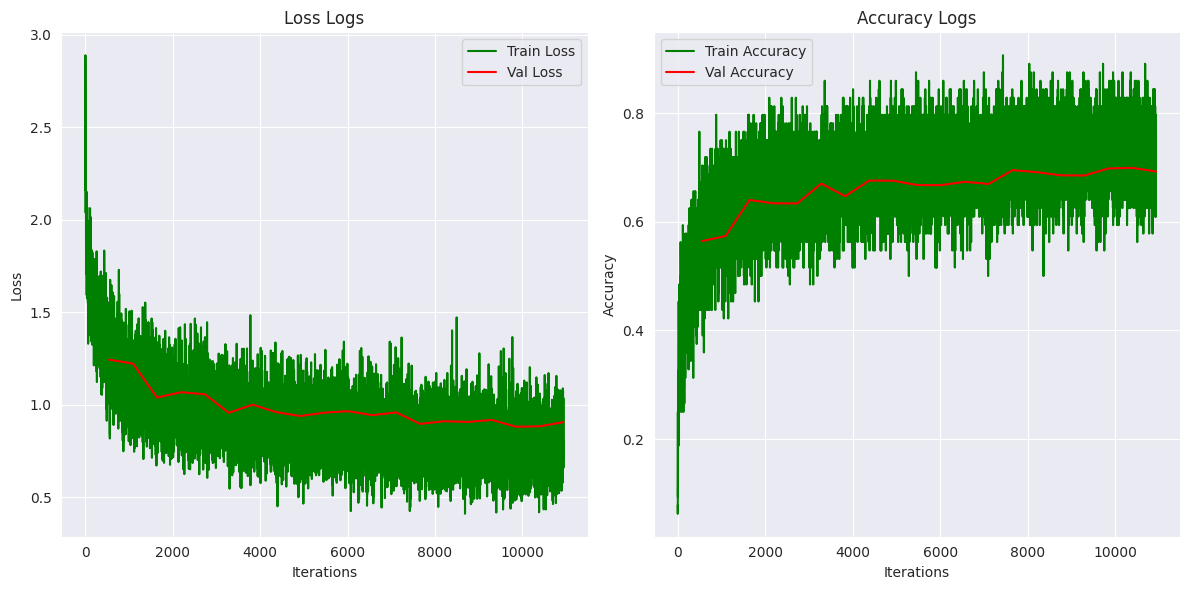

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.lineplot(ax=axs[0], x=np.arange(len(train_loss_log)), y=train_loss_log, label="Train Loss", color="g")
sns.lineplot(ax=axs[0], x=(np.arange(len(val_loss_log)) + 1) * len(train_loader), y=val_loss_log, label="Val Loss", color="r")
axs[0].set_title("Loss Logs")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Loss")
axs[0].legend()

sns.lineplot(ax=axs[1], x=np.arange(len(train_acc_log)), y=train_acc_log, label="Train Accuracy", color="g")
sns.lineplot(ax=axs[1], x=(np.arange(len(val_acc_log)) + 1) * len(train_loader), y=val_acc_log, label="Val Accuracy", color="r")
axs[1].set_title("Accuracy Logs")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()


## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.



Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.524658405693619, train acc: 0.4590542570328582
 val loss: 1.266477646726243, val acc: 0.557734929120287

Epoch 1
 train loss: 1.217823148863407, train acc: 0.5710205015142396
 val loss: 1.2426067740359206, val acc: 0.5780141844394359

Epoch 2
 train loss: 1.105219375280837, train acc: 0.6152389658652451
 val loss: 1.0947952757490442, val acc: 0.6228280143534883

Epoch 3
 train loss: 1.0360928234496107, train acc: 0.6413187190645138
 val loss: 1.0486202881691304, val acc: 0.6323581561129143

Epoch 4
 train loss: 1.0039950145010104, train acc: 0.6506349569700753
 val loss: 1.012625432268102, val acc: 0.6471631207364671

Epoch 5
 train loss: 0.9670641914800054, train acc: 0.6646113541705952
 val loss: 1.0130658651920075, val acc: 0.6436613476022761

Epoch 6
 train loss: 0.9437307157507763, train acc: 0.6724095717208695
 val loss: 0.9693068116269213, val acc: 0.6642952127659575

Epoch 7
 train loss: 0.9330672343862558, train acc: 0.6753762405794761
 val loss: 0.95247

Посчитайте точность на тестовой выборке:

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.7085987261146497


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8401933847441316, train acc: 0.35683680468764994
 val loss: 1.6364481936109827, val acc: 0.4247783688788718

Epoch 1
 train loss: 1.5433628042611605, train acc: 0.45766273832844206
 val loss: 1.4624213731035274, val acc: 0.4823581561129144

Epoch 2
 train loss: 1.4260809131688565, train acc: 0.4994368634886454
 val loss: 1.3769003482575113, val acc: 0.5081117021276595

Epoch 3
 train loss: 1.3620566853221636, train acc: 0.5205218399682472
 val loss: 1.3197852768796556, val acc: 0.534375

Epoch 4
 train loss: 1.3107782186058365, train acc: 0.5413660551991716
 val loss: 1.282266575478493, val acc: 0.5498670212765957

Epoch 5
 train loss: 1.2631042765307035, train acc: 0.5588559350322326
 val loss: 1.2263764650263684, val acc: 0.5721409574468085

Epoch 6
 train loss: 1.2219169638928373, train acc: 0.5735097284508798
 val loss: 1.2090869398827249, val acc: 0.5813608156873825

Epoch 7
 train loss: 1.186349580013338, train acc: 0.5858375228519196
 val loss: 1.161241399

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.6267914012738853


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.535175300385442, train acc: 0.4497625033423931
 val loss: 1.3282075775430557, val acc: 0.5271941489361702

Epoch 1
 train loss: 1.2404364916262722, train acc: 0.5595088470352633
 val loss: 1.2058851767093577, val acc: 0.5651374114320633

Epoch 2
 train loss: 1.1012648394164481, train acc: 0.6129088861632827
 val loss: 1.1117512038413515, val acc: 0.6140735816448293

Epoch 3
 train loss: 1.0135499952698102, train acc: 0.6475662705667276
 val loss: 1.0112743283839936, val acc: 0.6464095744680851

Epoch 4
 train loss: 0.9678599380052068, train acc: 0.6621466114490516
 val loss: 0.9753713016814374, val acc: 0.6612145390916377

Epoch 5
 train loss: 0.9342839693892373, train acc: 0.6760740402193784
 val loss: 0.9326765372398051, val acc: 0.6775487590343394

Epoch 6
 train loss: 0.9082416873527401, train acc: 0.6850964677617144
 val loss: 0.9487929983341947, val acc: 0.6737810284533399

Epoch 7
 train loss: 0.8832505819348574, train acc: 0.692286661054796
 val loss: 0.9

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.7038216560509554


In [ ]:
net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=8, power=3.0)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.540685699016564, train acc: 0.4523823126142596
 val loss: 1.3405718493968883, val acc: 0.5201684397585848

Epoch 1
 train loss: 1.2153541366186613, train acc: 0.56964530565621
 val loss: 1.2070189351731158, val acc: 0.5762189718002969

Epoch 2
 train loss: 1.061850361131009, train acc: 0.6285379668476376
 val loss: 1.0934397892749055, val acc: 0.6220523050490846

Epoch 3
 train loss: 0.9776521662907365, train acc: 0.6594737529536706
 val loss: 1.002514868086957, val acc: 0.6484485816448293

Epoch 4
 train loss: 0.9288111937111431, train acc: 0.6759965069987003
 val loss: 0.9536738525045679, val acc: 0.670035461161999

Epoch 5
 train loss: 0.8951621075216987, train acc: 0.6902952794618973
 val loss: 0.931164991094711, val acc: 0.6787012412192973

Epoch 6
 train loss: 0.8793891559353259, train acc: 0.696526508226691
 val loss: 0.9195782466137663, val acc: 0.6825576241980208

Epoch 7
 train loss: 0.8727941037967828, train acc: 0.6983342583698154
 val loss: 0.9163687

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.6538614649681529


In [ ]:
net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4740529237979072, train acc: 0.47480575868372943
 val loss: 1.265335273489039, val acc: 0.5597739361702128

Epoch 1
 train loss: 1.146548030036459, train acc: 0.5995935623345036
 val loss: 1.081364678068364, val acc: 0.6247340425531915

Epoch 2
 train loss: 1.0360006307553111, train acc: 0.6376746539877799
 val loss: 1.012052945634152, val acc: 0.6446808510638298

Epoch 3
 train loss: 0.9683894251338743, train acc: 0.6625669235721149
 val loss: 0.9835960413547272, val acc: 0.6539228723404256

Epoch 4
 train loss: 0.9236281611147921, train acc: 0.6805301645338209
 val loss: 0.9577774103651655, val acc: 0.6657801420130628

Epoch 5
 train loss: 0.8887756436354936, train acc: 0.6919561243144424
 val loss: 0.9614685999586227, val acc: 0.6671764186088075

Epoch 6
 train loss: 0.8612104713154013, train acc: 0.7032106948073211
 val loss: 0.934815184106218, val acc: 0.6753546100981692

Epoch 7
 train loss: 0.8381166537130554, train acc: 0.7100989162595006
 val loss: 0.896

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.7190485668789809


Your answers here:
- CyclicLR Scheduler - использует циклический LR в рамках заданного диапазона, меняется каждый батч
- PolynomialLR - собственно полиномиально меняет LR в соотв-ии с заданной степенью и количеством итераций до 0
- ExponentialLR - lr_k+1 = gamma * lr_k

Получилось добиться улучшения, используя ExponentialLR. CyclicLR сравнимо с предыдущим результатом, но так-то и параметры в планировщиках не подбирала.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.



Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

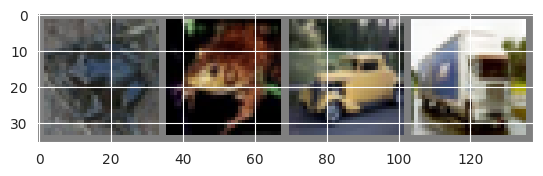

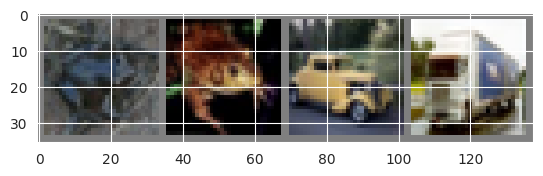

In [ ]:
dataiter = iter(train_loader)

images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images[:4]))



imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(

        [transforms.RandomHorizontalFlip(),

         transforms.ToTensor(),

         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)



train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)



net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4581827917962014, train acc: 0.48122061900726404
 val loss: 1.21085571202826, val acc: 0.5703235816448293

Epoch 1
 train loss: 1.142564994652485, train acc: 0.5978225385685072
 val loss: 1.0953163339736613, val acc: 0.6202349292471053

Epoch 2
 train loss: 1.0490527294671514, train acc: 0.6354669953613002
 val loss: 1.031701461812283, val acc: 0.643971631374765

Epoch 3
 train loss: 0.9957527503017097, train acc: 0.6566662314387083
 val loss: 1.0037002380858076, val acc: 0.65625

Epoch 4
 train loss: 0.955756584948552, train acc: 0.6681656438646194
 val loss: 0.9943390435360847, val acc: 0.6554521276595745

Epoch 5
 train loss: 0.9276315527380712, train acc: 0.678506137466082
 val loss: 0.9804589172627064, val acc: 0.6578235816448292

Epoch 6
 train loss: 0.910201702900299, train acc: 0.6850556608091979
 val loss: 0.9172156833587809, val acc: 0.6809618795171697

Epoch 7
 train loss: 0.89

Посчитайте точность на тестовой выборке:

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.7203423566878981


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
transform = transforms.Compose(

        [transforms.RandomAffine(degrees=0),

         transforms.ToTensor(),

         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)



train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4711917303162039, train acc: 0.47551171980130824
 val loss: 1.269032824293096, val acc: 0.5413120567798615

Epoch 1
 train loss: 1.1509139531273294, train acc: 0.5984550470407963
 val loss: 1.1113193580444822, val acc: 0.6109485816448292

Epoch 2
 train loss: 1.0356618963604218, train acc: 0.6380215134655536
 val loss: 1.0097879082598584, val acc: 0.6506870569066798

Epoch 3
 train loss: 0.977192619818874, train acc: 0.6600287282052816
 val loss: 0.9648428873812899, val acc: 0.6619459220703612

Epoch 4
 train loss: 0.9383384829465389, train acc: 0.6727809154137397
 val loss: 1.0049088303078997, val acc: 0.6476063829787234

Epoch 5
 train loss: 0.918162029556644, train acc: 0.680624020709852
 val loss: 0.9400520956262629, val acc: 0.6731161348363186

Epoch 6
 train loss: 0.8940381855589816, train acc: 0.6890302625173189
 val loss: 0.9716131486791245, val acc: 0.6639627659574469

Epoch 7
 t

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.7128781847133758


In [ ]:
transform = transforms.Compose(

        [transforms.ColorJitter(),

         transforms.ToTensor(),

         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)



train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4707482055074772, train acc: 0.47693996477388595
 val loss: 1.2900749586998148, val acc: 0.5372783688788718

Epoch 1
 train loss: 1.150124289000056, train acc: 0.5964840689786391
 val loss: 1.111322358567664, val acc: 0.6105274823117763

Epoch 2
 train loss: 1.0382448172220582, train acc: 0.6386744254685843
 val loss: 1.0099041373171704, val acc: 0.6533909574468085

Epoch 3
 train loss: 0.9772639400998243, train acc: 0.6602735701383141
 val loss: 0.9930730959202381, val acc: 0.6585771276595744

Epoch 4
 train loss: 0.9385905087103138, train acc: 0.6729196592266424
 val loss: 1.0039694618671497, val acc: 0.652969858240574

Epoch 5
 train loss: 0.915757663180231, train acc: 0.6813340625117859
 val loss: 0.9611993787136484, val acc: 0.6654033688788719

Epoch 6
 train loss: 0.8919168081972237, train acc: 0.6895893184532849
 val loss: 1.006241825540015, val acc: 0.6527039007937655

Epoch 7
 tr

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.7138734076433121


In [ ]:
transform = transforms.Compose(

        [transforms.RandomPerspective(distortion_scale=0.2),

         transforms.ToTensor(),

         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)



train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5773265117701054, train acc: 0.43307244058500916
 val loss: 1.4016753759789975, val acc: 0.4933953901554676

Epoch 1
 train loss: 1.287694822390729, train acc: 0.5419414338725577
 val loss: 1.1945544887096324, val acc: 0.5805851063829788

Epoch 2
 train loss: 1.1729555967956835, train acc: 0.5861272526397565
 val loss: 1.125551901218739, val acc: 0.60600620584285

Epoch 3
 train loss: 1.10547465707092, train acc: 0.611211315042576
 val loss: 1.1178741777196843, val acc: 0.6172207446808511

Epoch 4
 train loss: 1.0581912535636038, train acc: 0.6305048642254398
 val loss: 1.183833970668468, val acc: 0.5917774823117763

Epoch 5
 train loss: 1.0291127938457119, train acc: 0.6412819926873857
 val loss: 1.063664176362626, val acc: 0.6251551420130628

Epoch 6
 train loss: 1.001485330640071, train acc: 0.6494964416763682
 val loss: 0.985073105578727, val acc: 0.6559618795171697

Epoch 7
 train lo

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.7053144904458599


Your answers here:
- RandomAffine - рандомное афинное преобразование
- ColorJitter - рандомно меняет контраст, насыщенность яркость
- RandomPerspective - рандомно искажает перспективу картинки

Почти любая трансформация лучше, чем бейзлан (кроме RandomPerspective), но все три, выбранные мной, хуже чем RandomHorizontalFLip(), возможно сложновато для модели.

Поскольку RandomPersepective была хуже всех, я возьму вместо нее RandomHorizontalFlip

In [ ]:
transform = transforms.Compose(
        [transforms.ColorJitter(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomAffine(degrees=0),

         transforms.ToTensor(),

         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)



train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4791209345761775, train acc: 0.47450786763614883
 val loss: 1.276726608834368, val acc: 0.5410904255319149

Epoch 1
 train loss: 1.1584971170102873, train acc: 0.5930848459439042
 val loss: 1.096473098562119, val acc: 0.6184175531914894

Epoch 2
 train loss: 1.048578544770124, train acc: 0.635870984637977
 val loss: 1.0162671535573107, val acc: 0.6521719859001485

Epoch 3
 train loss: 0.9915592850235306, train acc: 0.6568743471035792
 val loss: 0.9770073129775676, val acc: 0.6618351063829787

Epoch 4
 train loss: 0.9494633632124669, train acc: 0.6693572081639082
 val loss: 1.010661138625855, val acc: 0.646187943346957

Epoch 5
 train loss: 0.9270274531252859, train acc: 0.6801506594722406
 val loss: 0.9563354956342819, val acc: 0.662455673801138

Epoch 6
 train loss: 0.907829252577351, train acc: 0.685361713334455
 val loss: 0.9453459529166526, val acc: 0.6707890071767442

Epoch 7
 train 

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.7254179936305732


Пока наш лучший результат

И с наилучшим LR-планировщиком получаем

In [ ]:
transform = transforms.Compose(
        [transforms.ColorJitter(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomAffine(degrees=0),

         transforms.ToTensor(),

         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)



train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.476120848651342, train acc: 0.4767604140084666
 val loss: 1.2606870889663697, val acc: 0.5511081561129144

Epoch 1
 train loss: 1.1456889704114994, train acc: 0.6002546357062443
 val loss: 1.0832591881143285, val acc: 0.6240913122258288

Epoch 2
 train loss: 1.0339799824100961, train acc: 0.6391681901279708
 val loss: 1.0247474989992507, val acc: 0.6456338654173182

Epoch 3
 train loss: 0.9755119877497936, train acc: 0.6616161204125371
 val loss: 0.9407103137767061, val acc: 0.6774157803109352

Epoch 4
 train loss: 0.9290336764926667, train acc: 0.6788856425276623
 val loss: 0.9610004323594113, val acc: 0.6666888297872341

Epoch 5
 train loss: 0.9026184964659445, train acc: 0.6870348002400651
 val loss: 0.9333723164619283, val acc: 0.6716312058428501

Epoch 6
 train loss: 0.881580763750146, train acc: 0.6941270566727605
 val loss: 0.8896686858319222, val acc: 0.689561170212766

Epoch 7
 t

In [ ]:
loss, acc = test(net, test_loader)
print(acc)

0.7179538216560509


Хуже, чем с MultiStep :(. Ну что ж, остановимся на 72.5%

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).



Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
def test(model, loader):

    loss_log = []

    acc_log = []

    model.eval()

    for data, target in loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pred = torch.argmax(output, dim=1)
        acc = torch.mean((pred == target).float())
        loss = F.cross_entropy(output, target)
        loss_log.append(loss.item())
        acc_log.append(acc.item())
    val_loss =  np.mean(loss_log)
    val_acc =  np.mean(acc_log)
    wandb.log({
        'Validation Loss': val_loss,
        'Validation Accuracy': val_acc,
    })
    return val_loss, val_acc



def train_epoch(model, optimizer, train_loader):

    loss_log = []

    acc_log = []

    model.train()


    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        pred = torch.argmax(output, dim=1)
        acc = torch.mean((pred == target).float())
        loss =  F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
        acc_log.append(acc.item())
        wandb.log({
                'Train Loss': loss.item(),
                'Train Accuracy':acc.item(),
        })
    return loss_log, acc_log



def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):

    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []



    for epoch in range(n_epochs):

        train_loss, train_acc = train_epoch(model, optimizer, train_loader)

        val_loss, val_acc = test(model, val_loader)


        train_loss_log.extend(train_loss)

        train_acc_log.extend(train_acc)



        val_loss_log.append(val_loss)

        val_acc_log.append(val_acc)



        print(f"Epoch {epoch}")

        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")

        print(f" val loss: {val_loss}, val acc: {val_acc}\n")



        if scheduler is not None:

            scheduler.step()



    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
transform = transforms.Compose(

        [transforms.ToTensor(),

         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)



train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,

                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
net = BasicBlockNet().to(device)

In [ ]:
import wandb

wandb.init(project='MNIST')
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

wandb.finish()

Train Accuracy,▃▃▃▃▇▁▄▃▅▂▅▆▄▇▅▃▃▃▇▆▃▅▇▅▄▅▅▃█▄▅▆▅▅▅▁▅▃▃▃
Train Loss,▂▇▇▄▇▅▅▂█▃▆█▅▇▇▆▄▂▆▇█▁▁▆▄▃█▇▅▅▇▇▄▂▂▄▃▇▇▃
Validation Accuracy,▆▁▄▄▂█▇▄▆▇█
Validation Loss,▃█▄▄▅▁▂▄▃▂▁
Train Accuracy,0.75
Train Loss,0.7105
Validation Accuracy,0.72784
Validation Loss,0.80792


Epoch 0
 train loss: 1.6006380413306478, train acc: 0.42879586714495255
 val loss: 1.4141442694562547, val acc: 0.5074689716734785

Epoch 1
 train loss: 1.3364714259857233, train acc: 0.5270795246800731
 val loss: 1.244244027391393, val acc: 0.555673758907521

Epoch 2
 train loss: 1.204708086507194, train acc: 0.576260120166939
 val loss: 1.1468338448950586, val acc: 0.5996897164811479

Epoch 3
 train loss: 1.1262731115168583, train acc: 0.6032172238804958
 val loss: 1.2142075624871762, val acc: 0.5660904255319149

Epoch 4
 train loss: 1.0737629026120061, train acc: 0.6239186146141624
 val loss: 1.04701618311253, val acc: 0.6370345744680851

Epoch 5
 train loss: 1.037941673011187, train acc: 0.6366259140767825
 val loss: 1.0744268280394533, val acc: 0.6309840425531915

Epoch 6
 train loss: 1.017992687399688, train acc: 0.6451831418591836
 val loss: 1.0814669500006007, val acc: 0.622938829787234

Epoch 7
 train loss: 1.0024219758985684, train acc: 0.6488884174191756
 val loss: 1.0457423

Train Accuracy,▄▆▁▄▄▄▆▇▅▆▃▆▄▆▆▅▇▅▅▇▅▇▆▆▇▄▅▆▇▇▆▆▆▇▅▅▇▅▄█
Train Loss,█▆▅▅▄▄▃▃▃▄▄▃▂▃▃▃▄▄▄▃▃▂▂▃▄▃▂▂▃▃▄▂▃▂▂▁▃▄▃▃
Validation Accuracy,▁▃▅▃▆▆▆▆▇▇▇▇█▇▇██▇██
Validation Loss,█▆▄▅▃▃▃▃▂▂▂▂▁▂▂▁▁▁▁▁
Train Accuracy,0.60714
Train Loss,1.01849
Validation Accuracy,0.67866
Validation Loss,0.93623


In [ ]:
wandb.init(project='MNIST')
loss, acc = test(net, test_loader)
wandb.finish()

wandb: Currently logged in as: hoshicasia_ (hoshicasia_-hse-university). Use `wandb login --relogin` to force relogin


Validation Accuracy,▁
Validation Loss,▁
Validation Accuracy,0.67008
Validation Loss,0.94849


Графики:
https://api.wandb.ai/links/hoshicasia_-hse-university/szfjov8n
https://api.wandb.ai/links/hoshicasia_-hse-university/5bm1a9jr

Почему-то одинаковым цветом отображаются по ссылке(